In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply, expm

In [26]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz
    
    return Hxx, Hz

In [27]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


### Correlation function with Chebyshev Interpolation

In [28]:
import importlib

import sys
sys.path.append('/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/Chebyshev')

import Chebyshev as Cbs

importlib.reload(Cbs)



<module 'Chebyshev' from '/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/Chebyshev/Chebyshev.py'>

In [29]:
# compute correlator
n = 10
N = 2**n
dt = 1e-2

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

Ground state energy: -23.26640793492973
Excited state energy: -19.529530591449653


2 20
2 20


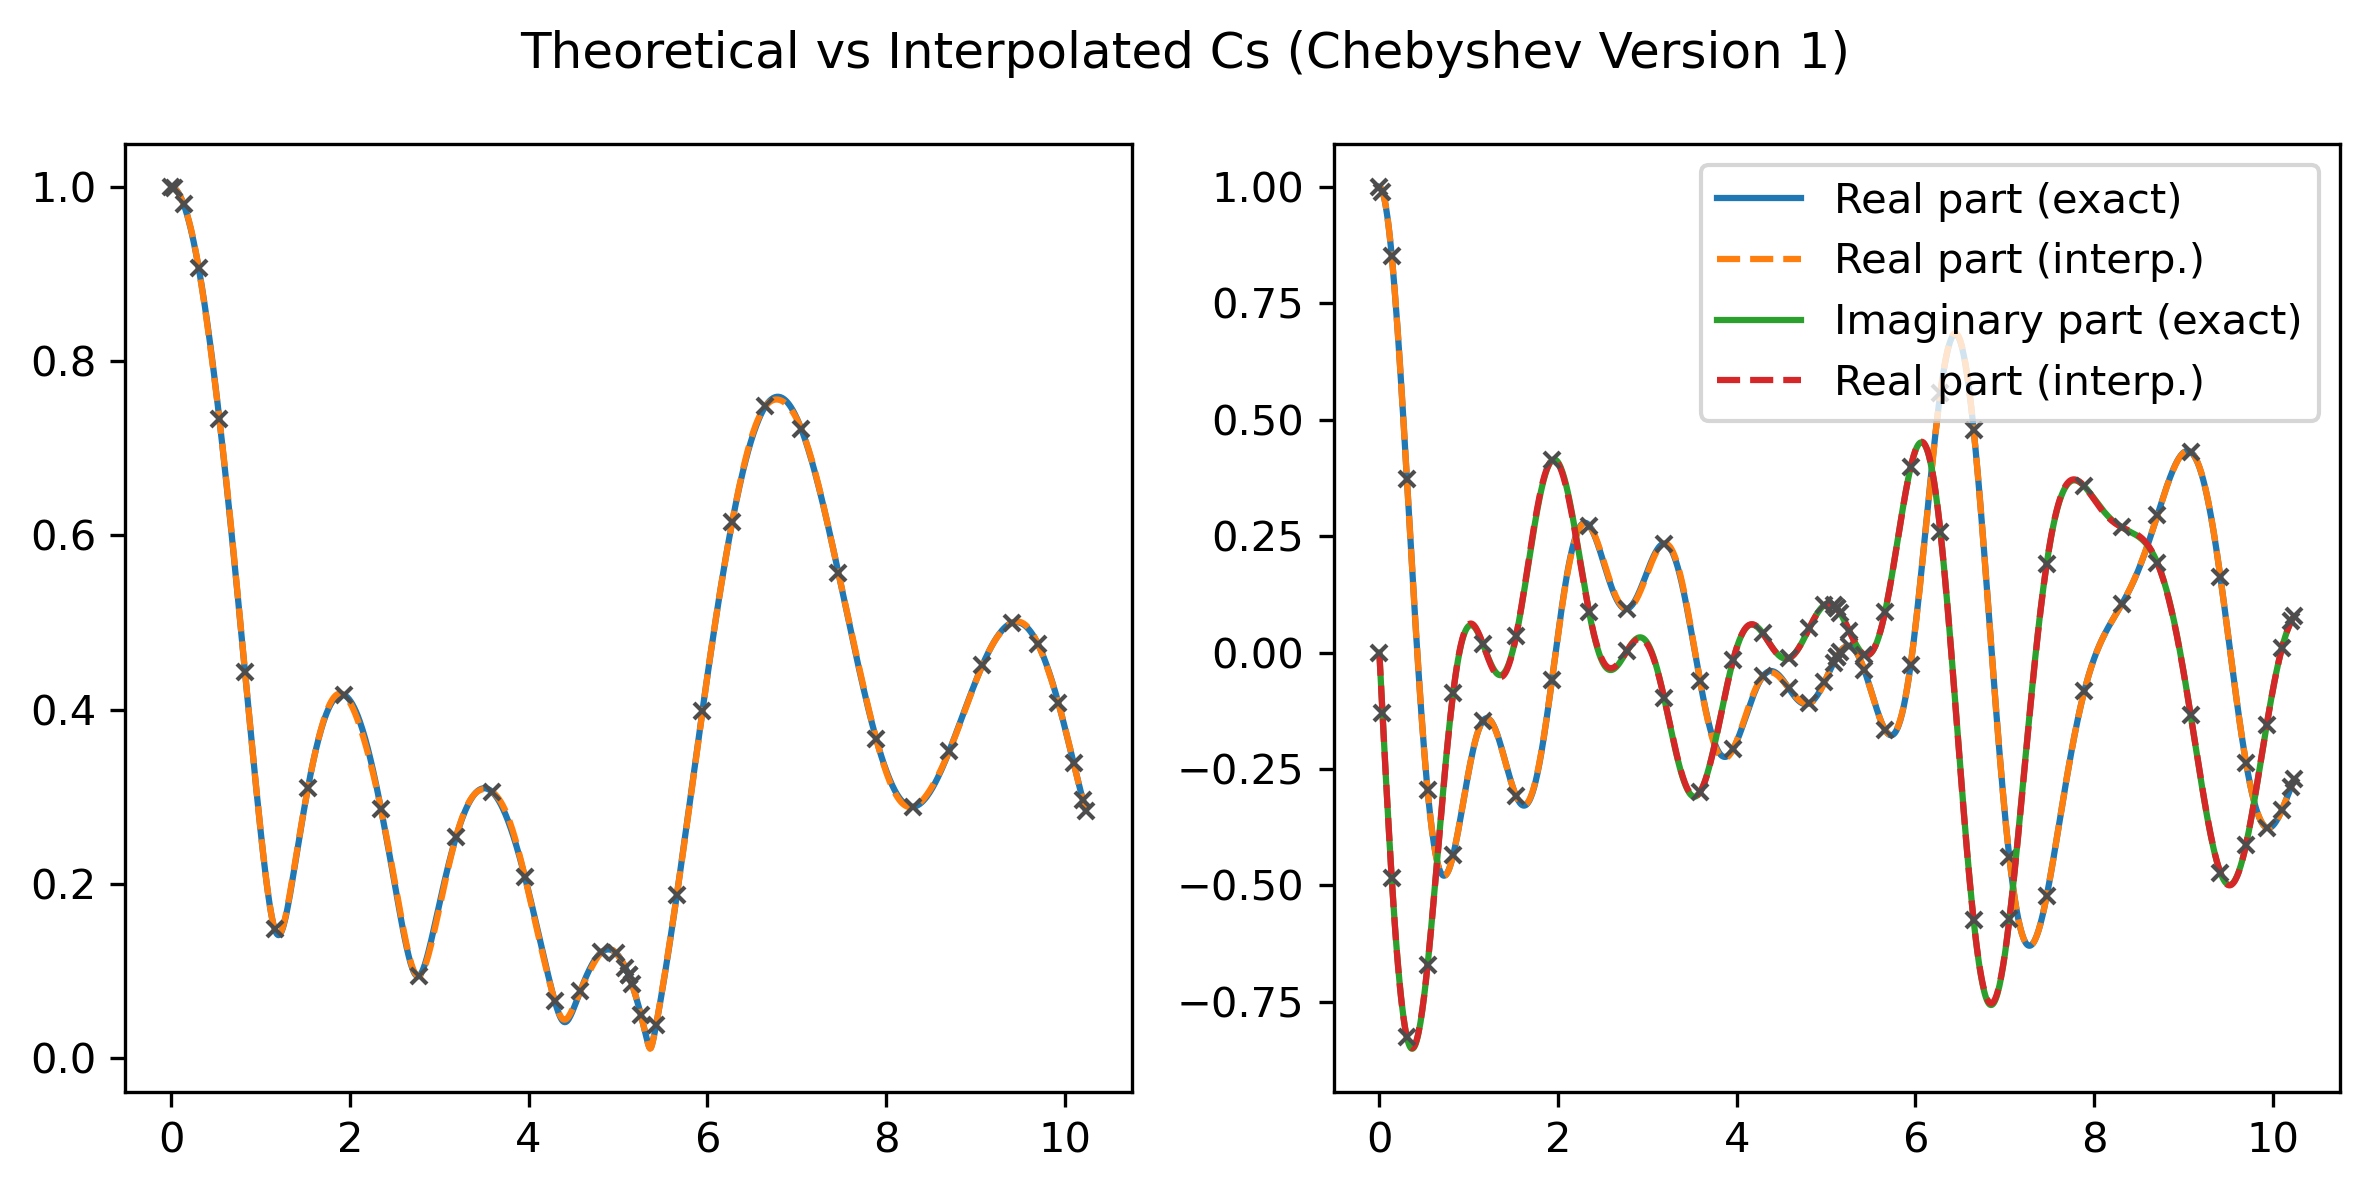

In [55]:
# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
def Cs_chebyshev(t_matrix, psi = psi):
    a,b = t_matrix.shape
    print(a, b)
    t = t_matrix.reshape(-1)*N*dt
    psis = np.zeros((a*b,psi.shape[0]), dtype=np.complex128)
    for i,tt in enumerate(t):
        psis[i,:] = expm_multiply(-1j * H * tt, psi)
    corr = np.einsum('j, ij -> i', psi.conj(), psis) * np.exp(1j * E0 * t)
    return corr.reshape(a, b)


#print(Cs_chebyshev(20))


#use numpy.save, numpy.savez, hdf5 file


# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# exact function values
#xs = np.linspace(0, N*dt, 2**n, endpoint=False)
xs = np.arange(N)*dt

# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
Cs = np.einsum('j, ij -> i', psi.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)
func_vals = Cs

# get MPS from Chebyshev interpolation
chi = 20
As, _, _, _, _ = Cbs.Chebyshev_interpolation(Cs_chebyshev, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 chi=chi)           # (half of the) bond dimension
# also plot points on which the function was evaluated
Cheb_xs = 0.5 * np.sort(np.arange(2)[:, None] + Cbs.c_a_N(np.arange(chi), chi-1)[None, :])
Cheb_vals = Cs_chebyshev(Cheb_xs)
Cheb_xs *= N*dt

# contract MPS to reconstruct interpolated function
func_interp = Cbs.interpolate_singlesite(As)

# plot results
fig, axs = plt.subplots(ncols=2, dpi=300, figsize=(8,4), sharex=True)

axs[0].plot(xs, np.abs(func_vals))
axs[0].plot(xs, np.abs(func_interp), '--')
axs[0].plot(Cheb_xs, np.abs(Cheb_vals), 'x', ms=4, color='0.3')

axs[1].plot(xs, func_vals.real, label='Real part (exact)')
axs[1].plot(xs, func_interp.real, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.real, 'x', ms=4, color='0.3')
axs[1].plot(xs, func_vals.imag, label='Imaginary part (exact)')
axs[1].plot(xs, func_interp.imag, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.imag, 'x', ms=4, color='0.3')
axs[1].legend()
fig.suptitle("Theoretical vs Interpolated Cs (Chebyshev Version 1)")

plt.tight_layout()
plt.show()


### Error vs evals for Chebyshev

In [31]:
#here we could define a dictionary to make things more compact
err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(2,10)]
chi_list.extend([i for i in range(10,40,5)])
chi_list.append(70)

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation(Cs_chebyshev, # function to be interpolated
                                     func_vals,
                                     L=n,              # number of MPS tensors
                                     chi=chi)           # (half of the) bond dimension
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)




2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 15
2 20
2 25
2 30
2 35
2 70


In [ ]:
chi_list.append(200)
chi_list.append(400)
for chi in chi_list[-2:]:
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation(Cs_chebyshev, # function to be interpolated
                                     func_vals,
                                     L=n,              # number of MPS tensors
                                     chi=chi)           # (half of the) bond dimension
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)


2 200
2 400


In [32]:
print(evals)
#print(func_interp_list)

[4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 140]


In [33]:
if 'err_max' in locals() or 'err_max' in globals():
    np.save("err_max", err_max)
    np.save("err_2", err_2)
    np.save("evals", evals)
    np.save 
else:
    err_max = np.load("err_max")
    err_2 = np.load("err_2")
    evals = np.load("evals")

In [34]:
print(err_2)

[1.387665934039555, 1.3317524567075103, 1.386000459819862, 1.1101240014116183, 0.9490240807949686, 0.7661394940571545, 0.6632994081608409, 0.6055316271436184, 0.5292779880417731, 0.14451634426544782, 0.005546926035409387, 0.00045446681313900496, 0.00014784160996974362, 2.5400293745286078e-05, 3.601601680628542e-13]


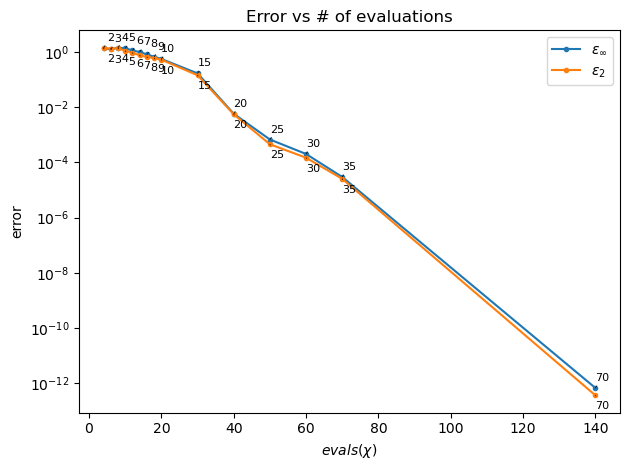

In [35]:
plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

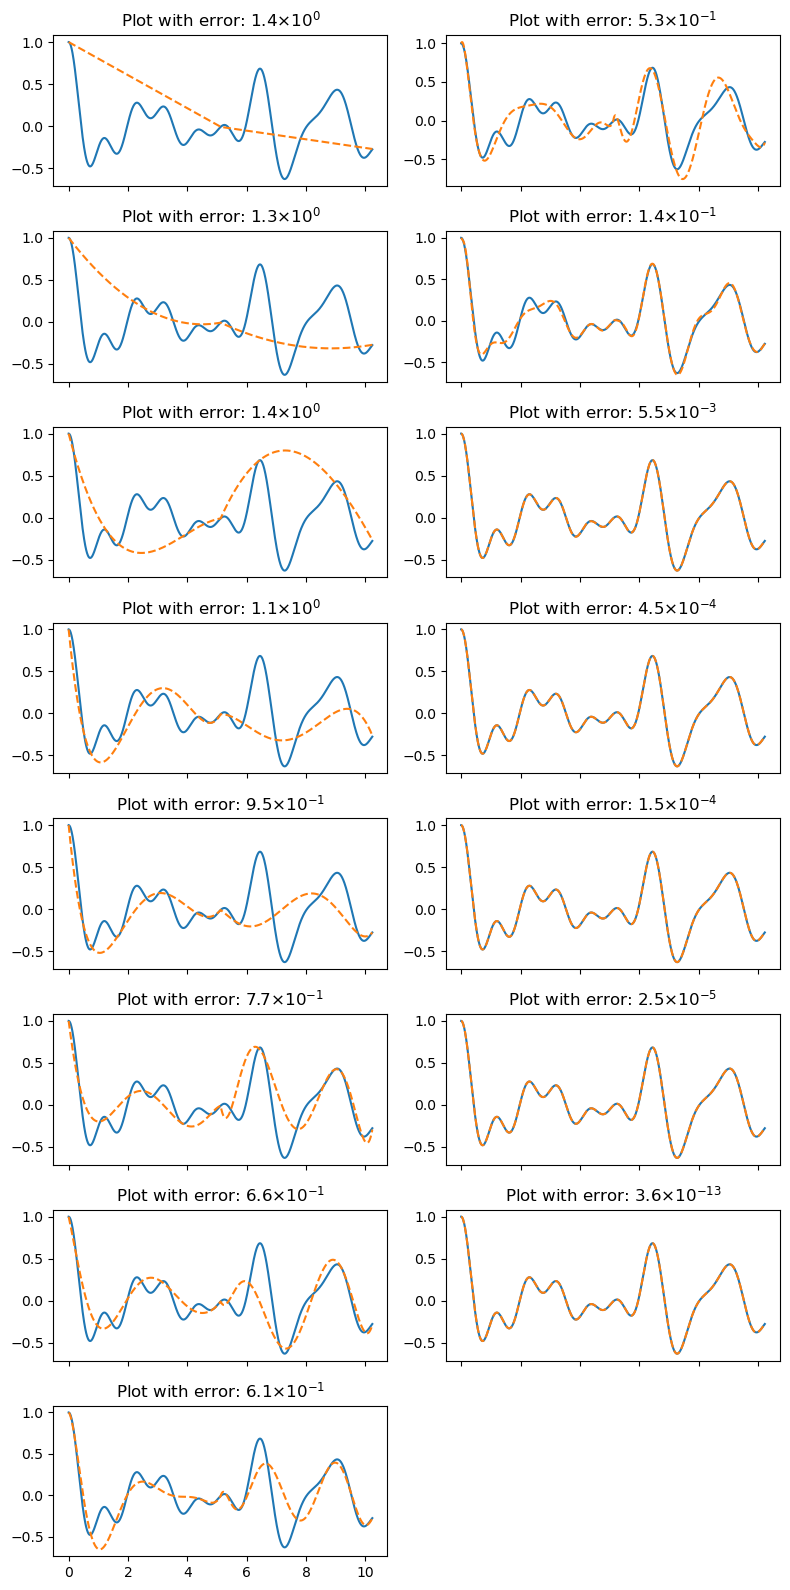

In [57]:
# Determine the number of rows and columns
n_plots = len(func_interp_list)
ncols = 2
nrows = (n_plots + 1) // 2  # Ensure enough rows for all plots

# Create subplots with a grid layout
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 2 * nrows), sharex=True)

# Flatten `axs` for easier indexing (handles both 2D and 1D cases)
axs = np.array(axs).T.flatten()

for i,element in enumerate(func_interp_list):
    axs[i].plot(xs, np.real(func_vals), '-')
    axs[i].plot(xs, np.real(element), '--')
    #axs[i].plot(xs, np.imag(func_vals), '-')
    #axs[i].plot(xs, np.imag(element), '--')
    exponent = int(np.floor(np.log10(err_2[i])))  # Get the exponent
    mantissa = err_2[i] / (10 ** exponent)  # Get the mantissa
    #axs[i].set_title(f"Plot with error: {err_2[i]:.2e}")
    axs[i].set_title(f"Plot with error: {mantissa:.1f}×10$^{{{exponent}}}$")

for j in range(len(func_interp_list), len(axs)):
    fig.delaxes(axs[j])  # Remove empty subplot

fig.tight_layout()

In [45]:
importlib.reload(Cbs)

<module 'Chebyshev' from '/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/Chebyshev/Chebyshev.py'>

### Version 2

(1, 40)
1 40
1 40


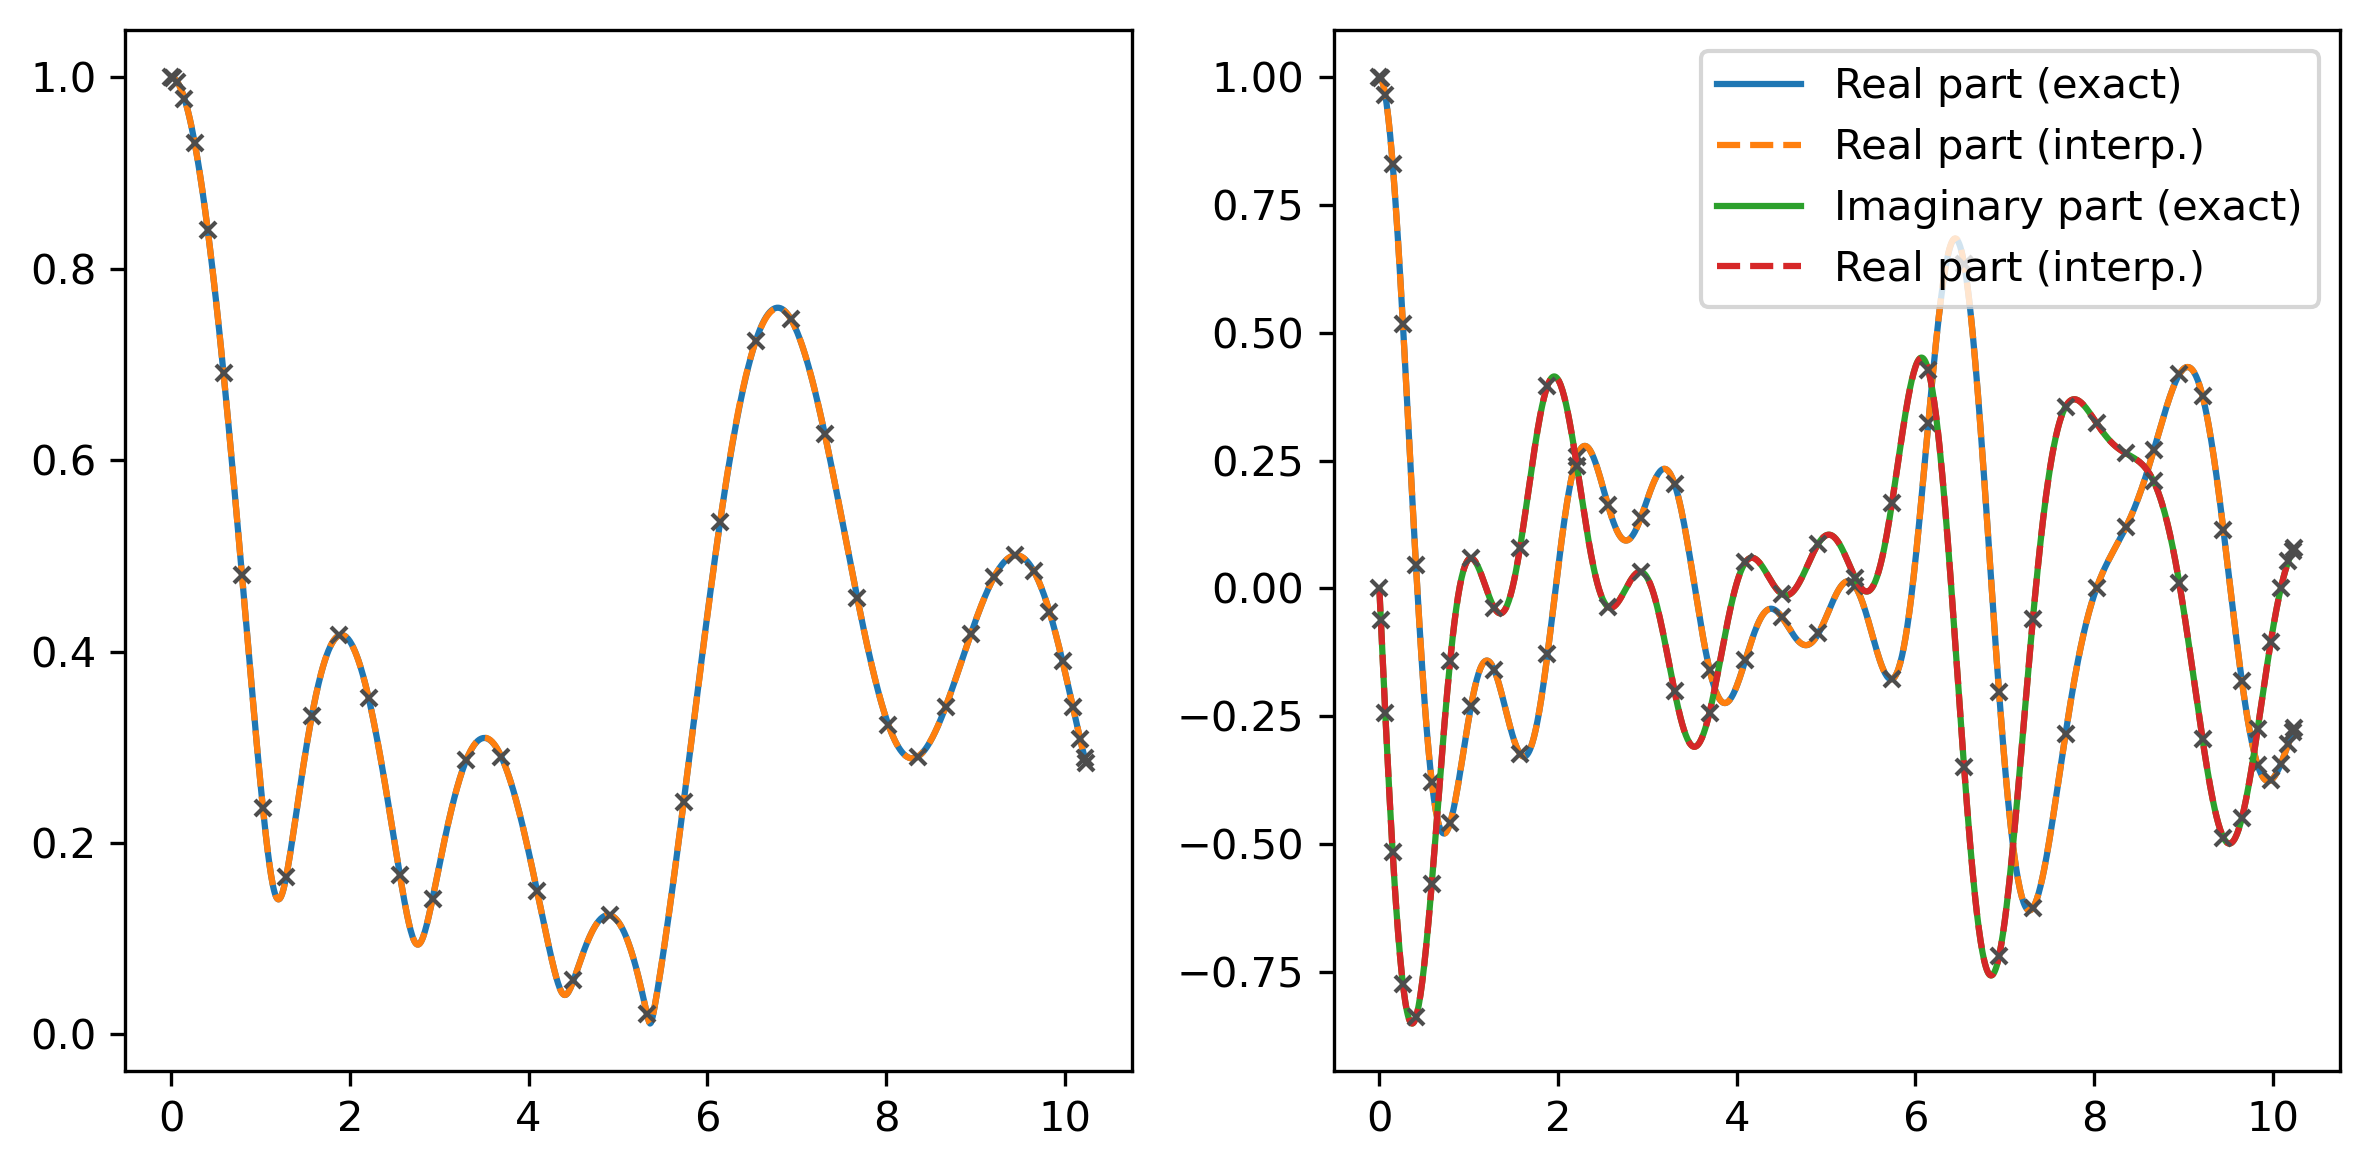

In [24]:
# get MPS from Chebyshev interpolation
chi = 40
As, _, _, _, _ = Cbs.Chebyshev_interpolation_version2(Cs_chebyshev, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 chi=chi)           # (half of the) bond dimension
# also plot points on which the function was evaluated
Cheb_xs = Cbs.c_a_N(np.arange(chi), chi-1)[None]
Cheb_vals = Cs_chebyshev(Cheb_xs)
Cheb_xs *= N*dt

# contract MPS to reconstruct interpolated function
func_interp = Cbs.interpolate_singlesite(As)

# plot results
fig, axs = plt.subplots(ncols=2, dpi=300, figsize=(8,4), sharex=True)

axs[0].plot(xs, np.abs(func_vals))
axs[0].plot(xs, np.abs(func_interp), '--')
axs[0].plot(Cheb_xs, np.abs(Cheb_vals), 'x', ms=4, color='0.3')

axs[1].plot(xs, func_vals.real, label='Real part (exact)')
axs[1].plot(xs, func_interp.real, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.real, 'x', ms=4, color='0.3')
axs[1].plot(xs, func_vals.imag, label='Imaginary part (exact)')
axs[1].plot(xs, func_interp.imag, '--', label='Real part (interp.)')
axs[1].plot(Cheb_xs, Cheb_vals.imag, 'x', ms=4, color='0.3')
axs[1].legend()
fig.suptitle("Theoretical vs Interpolated Cs (Chebyshev Version 2)")


plt.tight_layout()
plt.show()


In [52]:
#here we could define a dictionary to make things more compact
err_max_v2 = []
err_2_v2 = []
evals_v2 = []
func_interp_list_v2 = []

chi_list = [i for i in range(4,20,2)]
chi_list.extend([i for i in range(20,75,10)])

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation_version2(Cs_chebyshev, # function to be interpolated
                                     func_vals,
                                     L=n,              # number of MPS tensors
                                     chi=chi)           # (half of the) bond dimension
    err_max_v2.append(errmax)
    err_2_v2.append(err2)
    evals_v2.append(eval)
    func_interp_list_v2.append(func_interp)

(1, 4)
1 4
(1, 6)
1 6
(1, 8)
1 8
(1, 10)
1 10
(1, 12)
1 12
(1, 14)
1 14
(1, 16)
1 16
(1, 18)
1 18
(1, 20)
1 20
(1, 30)
1 30
(1, 40)
1 40
(1, 50)
1 50
(1, 60)
1 60
(1, 70)
1 70


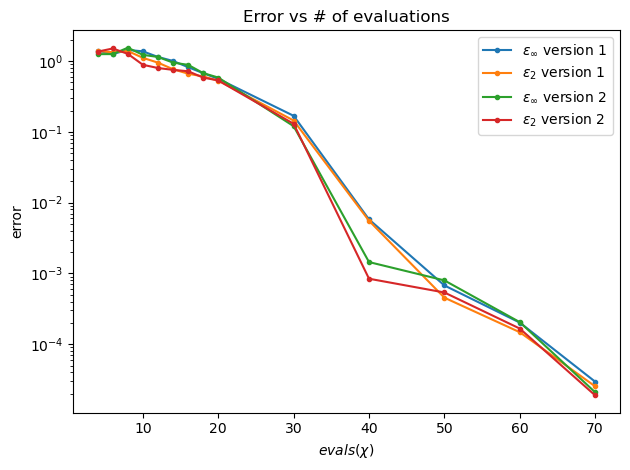

In [53]:
plt.plot(np.array(evals[:-1]), np.array(err_max[:-1]), ".-", label = r"$\epsilon_\infty$ version 1")
plt.plot(np.array(evals[:-1]), np.array(err_2[:-1]), ".-", label = r"$\epsilon_2$ version 1")
plt.plot(np.array(evals_v2), np.array(err_max_v2), ".-", label = r"$\epsilon_\infty$ version 2")
plt.plot(np.array(evals_v2), np.array(err_2_v2), ".-", label = r"$\epsilon_2$ version 2")


plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()